<a href="https://colab.research.google.com/github/alirezasakhaei/SPML_Course2023_Homeworks/blob/main/Defensive_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPML HW3 - Defensive Distillation (30)

### Deadline: 1402/2/30

#### Name: Alireza Sakhaeirad
#### Student No.: 98101714

In this notebook, you are going to attack a defensively distilled model

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the course page.

Also, it is recommended to use google colab to do this homework. You can connect to your drive using the code below:

## Additional Functions

In [29]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

def plot_acc_acc_loss(acc_train, acc_test, losses):
    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    ax1.plot(acc_train, label='train')
    ax1.plot(acc_test, label='test')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(losses, label='losses')
    ax2.legend()
    ax2.grid(True)
    plt.show()

## Resnet

In [9]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Initializations

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim

## Defining Teacher and Student Classes

In [11]:
class Teacher(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv = nn.Sequential(
        *list(resnet18(pretrained=False).children())[:-2])
    
    self.fc = nn.Linear(512, num_cls)
    self.temp = T
  
  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    output = torch.softmax(logits / T, dim=1)

    return logits, output

class Student(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_cls)
    self.temp = T

  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x)

    output = torch.softmax(logits / T, dim=1)
    return logits, output

In [68]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

###################### Problem 1 (3 points) ####################################
# todo: Define your data loaders for training, testing, and validation         #
################################################################################

# your code goes here

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
################################ End ###########################################

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


## Training

### Teacher Network Training

In [108]:
def standard_train(model, loader, num_epoch, optimizer, criterion, T=None, 
                   device=device):
  ###################### Problem 2 (4 points) ##################################
  # todo: Iterate over loader in each epoch                                    #
  # todo: Compute the model's output for each batch at the given temperature T #
  # todo: Compute the loss function and take a step by the optimizer           #
  # todo: Monitor the training procedure                                       #
  ##############################################################################

  # your code goes here
  for epoch in range(num_epoch):
        running_loss = 0.0
        
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Compute the model's output for each batch at the given temperature T
            if T is not None:
                logits, outputs = model(inputs, T=T)
            else:
                logits, outputs = model(inputs)
            
            optimizer.zero_grad()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Monitor the training procedure
        epoch_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {epoch_loss:.4f}")
  ##############################################################################

In [ ]:
T = 100
teacher = Teacher(len(classes), T=T).to(device)
teacher_optim = optim.Adam(teacher.parameters())
teacher_criterion = nn.CrossEntropyLoss()

In [110]:
standard_train(model=teacher, 
            loader=trainloader, 
            num_epoch=15, 
            optimizer=teacher_optim, 
            criterion=teacher_criterion, 
            T=T, 
            device=device)

Epoch 1/15, Loss: 2.1332
Epoch 2/15, Loss: 1.9631
Epoch 3/15, Loss: 1.8957
Epoch 5/15, Loss: 1.8006
Epoch 6/15, Loss: 1.7738
Epoch 7/15, Loss: 1.7539
Epoch 8/15, Loss: 1.7409
Epoch 9/15, Loss: 1.7284
Epoch 10/15, Loss: 1.7137
Epoch 11/15, Loss: 1.7017
Epoch 12/15, Loss: 1.6873
Epoch 13/15, Loss: 1.6801
Epoch 14/15, Loss: 1.6754
Epoch 15/15, Loss: 1.6649


### Student Network Training

In [113]:
def distillation(teacher, student, loader, num_epoch, optimizer, criterion, 
                 T=None, device=device):
  ###################### Problem 3 (6 points) ##################################
  # todo: Iterate over loader in each epoch                                    #
  # todo: Compute MSE loss between student's logit and teacher's logit         #
  # todo: Take a step by the optimizer                                         #
  # todo: Monitor the training procedure                                       #
  ##############################################################################

  # your code goes here
  losses = []
  acc_trains = []
  acc_tests = []


  teacher.eval()
  student.train()    
  for epoch in range(num_epoch):
      student.train()  
      running_loss = 0.0
      
      for inputs, labels in loader:
          inputs, labels = inputs.to(device), labels.to(device)
          teacher_logits, teachers_output = teacher(inputs, T=1)
          teacher_logits = teacher_logits.to(device)

          student_logits, students_outputs = student(inputs)
          
          optimizer.zero_grad()
          
          loss = criterion(student_logits, teacher_logits)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()
      
      # Monitor the training procedure
      epoch_loss = running_loss / len(loader)
      epoch_acc_train = standard_test(student, trainloader)
      epoch_acc_test =  standard_test(student, testloader)
      
      losses.append(epoch_loss)
      acc_trains.append(epoch_acc_train)
      acc_tests.append(epoch_acc_test)

      plot_acc_acc_loss(acc_trains, acc_tests, losses)

  ################################ End #########################################

In [131]:
T = 100
student = Student(len(classes), T=T).to(device)
student_optim = optim.Adam(student.parameters())
std_criterion = nn.MSELoss()

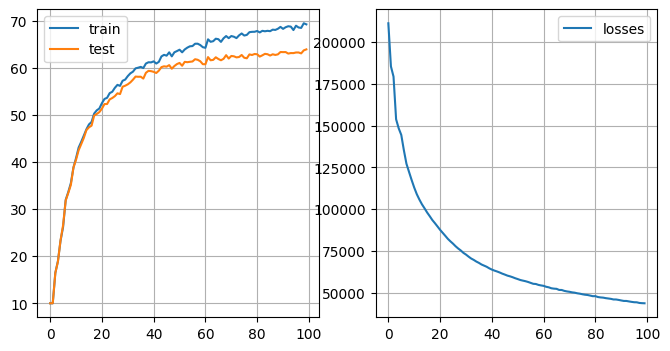

In [132]:
distillation(teacher=teacher, 
             student=student, 
             loader=trainloader, 
             num_epoch=100, 
             optimizer=student_optim, 
             criterion=std_criterion, 
             T=T, 
             device=device)

### Computing Clean Accuracy

In [115]:
def standard_test(model, loader, T=1, device=device):
  correct = 0
  total = 0
  ###################### Problem 4 (3 points) ##################################
  # todo: Iterate over loader, compute the output and predicted                #
  # label, and update "correct" and "total" counters accordingly.              # 
  ##############################################################################
  
  # your code goes here
  model.eval()  # Set the model to evaluation mode
  corrects = 0
  total = 0
  # Disable gradient computation for efficiency
  with torch.no_grad():
      for data in loader:
          # Get inputs and labels from the dataloader
          inputs, labels = data[0].to(device), data[1].to(device)

          # Forward pass through the network
          logits, outputs = model(inputs)
          
          # Get the predicted class with the highest score
          _, predicted = torch.max(logits.data, 1)

          # Count how many predictions were correct
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # Calculate the accuracy as the percentage of correct predictions
  accuracy = 100 * correct / total
  return accuracy
  ################################ End #########################################
  print(f'Clean accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [111]:
standard_test(teacher, testloader)

72.03

In [133]:
standard_test(student, testloader)

63.97

## Attacks

In [134]:
def fgsm_attack (model, X, y, epsilon, T=1, mode="output"):
  delta = torch.zeros_like(X, requires_grad=True).to(device)
  ###################### Problem 5 (9 points) ######################
  # todo: Perform forward path on model with the image             #
  # todo: Compute loss:                                            #
  #       - In output mode, set cross entropy as the loss function #
  #       - In logit mode, set the logit value of the target label #
  #         as the loss function                                   #
  # todo: Perform backward path on loss function                   #
  # todo: Calculate the gradient w.r.t. the data                   #
  # todo: Determine delta based on the gradient and epsilon        #
  # Also, if the perturbed image exceeds the valid range, clamp    #
  # the delta in order to obtain an image in the valid range       #  
  ##################################################################

  # your code goes here
  # Forward pass
  logits, output = model(X + delta, T=T)

  # Compute loss
  if mode == "output":
      loss = F.cross_entropy(output, y)
  elif mode == "logit":
      extracted_logits = logits[torch.arange(logits.shape[0]), y]
      loss = - torch.sum(extracted_logits)
  else:
      raise ValueError("Invalid mode. Allowed modes: 'output', 'logit'")

  # Backward pass
  model.zero_grad()
  loss.backward(retain_graph=True)

  # Calculate gradient w.r.t. data
  grad = delta.grad.detach()

  # Determine delta based on the gradient and epsilon
  delta = epsilon * torch.sign(grad)

  # Clamp the delta to ensure valid range of perturbed image
  delta = torch.clamp(X + delta, 0, 1) - X
  ########################### End ##################################
    
  return delta + X

In [130]:
def attack_test(model, attack_model, loader, mode="output", epsilon=4/255, T=1, 
                device=device):
  correct = 0
  total = 0
  ###################### Problem 6 (4.5 points) ################################
  # todo: Iterate over loader                                                  #
  # todo: Find an adversarial example by FGSM attack on attack_model           #
  # todo: Compute the output and predicted label, and updated "correct" and    #
  # "total" counters accordingly.                                              # 
  ##############################################################################

  # your code goes here
  for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)
      
      # Perform FGSM attack on attack model to get adversarial example
      adv_images = attack_model(model, images, labels, epsilon, T, mode)
      
      # Compute output and predicted label from adversarially perturbed image
      _, adv_outputs = model(adv_images)
      _, adv_pred_labels = torch.max(adv_outputs.data, 1)
      
      # Update correct and total counters
      total += labels.size(0)
      correct += (adv_pred_labels == labels).sum().item()
  ################################ End #########################################
  print(f'Accuracy of the network on the 10000 test images after attacking {mode} layer: {100 * correct // total} %')

In [138]:
###################### Problem 7 (1.5 points) ##################################
# todo: Report the accuracy of the student model under attack output and logit #
#       layers                                                                 #
# todo: Do not forget to set the temperature of the student model to 1         #
################################################################################

# your code goes here
mode = "output"
attack_test(student, fgsm_attack, testloader, mode = mode)

mode = "logit"
attack_test(student, fgsm_attack, testloader, mode = mode)
################################ End ###########################################

Accuracy of the network on the 10000 test images after attacking output layer: 32 %
Accuracy of the network on the 10000 test images after attacking logit layer: 23 %
